### Imports

In [1]:
import os
import gc
import glob
import json
from collections import defaultdict
import multiprocessing as mp
from pathlib import Path
from types import SimpleNamespace
from typing import Dict, List, Optional, Tuple
import warnings

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import PIL.Image as Image
from sklearn.metrics import fbeta_score
from sklearn.exceptions import UndefinedMetricWarning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from tqdm import tqdm

### Set up data

In [2]:
BASE_PREFIX = Path('/kaggle/input/vesuvius-challenge/')
PREFIX = BASE_PREFIX / 'train/1/'
BUFFER = 30  # Buffer size in x and y direction
Z_START = 16 # First slice in the z direction to use
Z_DIM = 10   # Number of slices in the z direction
TRAINING_EPOCHS = 30000
VALIDATION_EPOCHS= 500
LEARNING_RATE = 0.03
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [3]:
class SubvolumeDataset(data.Dataset):
    def __init__(self, image_stack, label, pixels):
        self.image_stack = image_stack
        self.label = label
        self.pixels = pixels
    def __len__(self):
        return len(self.pixels)
    def __getitem__(self, index):
        y, x = self.pixels[index]
        subvolume = self.image_stack[:, y-BUFFER:y+BUFFER+1, x-BUFFER:x+BUFFER+1].view(1, Z_DIM, BUFFER*2+1, BUFFER*2+1)
        inklabel = self.label[y, x].view(1)
        return subvolume, inklabel   

In [102]:
class MiddleSquareDataset(SubvolumeDataset):
    """Label each square (of size (2*BUFFER) * (2*BUFFER) * Z_DIM) by square_side**2 binary
    outputs which are the middle square of ink labels.
    """
    def __init__(self, image_stack, label, pixels, square_side=2):
        super().__init__(image_stack, label, pixels)
        self.square_side = square_side
        
    def __getitem__(self, index):
        y, x = self.pixels[index]
        subvolume = self.image_stack[
            :, y-BUFFER:y+BUFFER+1, x-BUFFER:x+BUFFER+1
        ].view(1, Z_DIM, BUFFER*2+1, BUFFER*2+1)
        small_buffer = self.square_side//2
        # Labels are a 2D tensor
        inklabels = self.label[
            y-small_buffer:y-small_buffer+self.square_side,
            x-small_buffer:x-small_buffer+self.square_side
        ].flatten().to(DEVICE)
        return subvolume, inklabels
        

In [5]:
images = [np.array(Image.open(filename), dtype=np.float32)/65535.0 for filename in tqdm(sorted(PREFIX.glob("surface_volume/*.tif"))[Z_START:Z_START+Z_DIM])]
image_stack = torch.stack([torch.from_numpy(image) for image in images], dim=0).to(DEVICE)

100%|██████████| 10/10 [00:13<00:00,  1.37s/it]


In [6]:
mask = np.array(Image.open(PREFIX / "mask.png").convert('1'))
label = torch.from_numpy(np.array(Image.open(PREFIX / "inklabels.png"))).gt(0).float().to(DEVICE)

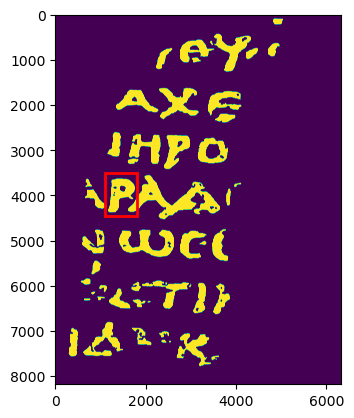

Generating pixel lists...


In [7]:
rect = (1100, 3500, 700, 950)
#rect = (1500, 2500, 1200, 1200)
fig, ax = plt.subplots()
ax.imshow(label.cpu())
patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(patch)
plt.show()


print("Generating pixel lists...")
# Split our dataset into train and val. The pixels inside the rect are the 
# val set, and the pixels outside the rect are the train set.
# Adapted from https://www.kaggle.com/code/jamesdavey/100x-faster-pixel-coordinate-generator-1s-runtime
# Create a Boolean array of the same shape as the bitmask, initially all True
not_border = np.zeros(mask.shape, dtype=bool)
not_border[BUFFER:mask.shape[0]-BUFFER, BUFFER:mask.shape[1]-BUFFER] = True
arr_mask = np.array(mask) * not_border
inside_rect = np.zeros(mask.shape, dtype=bool) * arr_mask
# Sets all indexes with inside_rect array to True
inside_rect[rect[1]:rect[1]+rect[3]+1, rect[0]:rect[0]+rect[2]+1] = True
# Set the pixels within the inside_rect to False
outside_rect = np.ones(mask.shape, dtype=bool) * arr_mask
outside_rect[rect[1]:rect[1]+rect[3]+1, rect[0]:rect[0]+rect[2]+1] = False
pixels_inside_rect = torch.tensor(np.argwhere(inside_rect)).to(DEVICE)
pixels_outside_rect = torch.tensor(np.argwhere(outside_rect)).to(DEVICE)

In [66]:
# This is sort of kludgy. I want to have models that predict the middle 2x2 ink labels
# from each large 60x60 square. The point, faster training and inference, is only achieved
# if we also use less training data. So I restrict the pixel lists to include only pixels
# with odd x and y coordinates.
# A better way to do this would be to have a dataloader-type class that does is fed the
# data directly (image stack, mask, validation rect, and labels), and produces the required
# pixel lists as a preprocessing step.
inside_rect_pixels = np.argwhere(inside_rect)
odd_inside_rect_pixels = inside_rect_pixels[np.nonzero((inside_rect_pixels[:, 0] % 2)
                                                       & (inside_rect_pixels[:, 1] % 2))]
outside_rect_pixels = np.argwhere(outside_rect)
odd_outside_rect_pixels = outside_rect_pixels[np.nonzero((outside_rect_pixels[:, 0] % 2)
                                                       & (outside_rect_pixels[:, 1] % 2))]
print(inside_rect_pixels.shape, odd_inside_rect_pixels.shape)
print(outside_rect_pixels.shape, odd_outside_rect_pixels.shape)
odd_inside_rect_pixels = torch.Tensor(odd_inside_rect_pixels).to(DEVICE, dtype=torch.int64)
odd_outside_rect_pixels = torch.Tensor(odd_outside_rect_pixels).to(DEVICE, dtype=torch.int64)


(666651, 2) (166250, 2)
(28470276, 2) (7117986, 2)


In [103]:
%%time
train_dset = SubvolumeDataset(image_stack,label, pixels_outside_rect)
val_dset = SubvolumeDataset(image_stack, label, pixels_inside_rect)

print("Num items (pixels)", len(train_dset))
print(train_dset[len(train_dset)//2])

Num items (pixels) 28470276
(tensor([[[[0.3569, 0.3544, 0.3517,  ..., 0.5748, 0.5330, 0.4630],
          [0.3961, 0.3981, 0.4019,  ..., 0.4919, 0.4548, 0.3966],
          [0.4343, 0.4372, 0.4382,  ..., 0.4067, 0.3721, 0.3237],
          ...,
          [0.3235, 0.2920, 0.2510,  ..., 0.3876, 0.4115, 0.4142],
          [0.3185, 0.3333, 0.3480,  ..., 0.3482, 0.3638, 0.3701],
          [0.3789, 0.4061, 0.4338,  ..., 0.3082, 0.3325, 0.3474]],

         [[0.3406, 0.3369, 0.3337,  ..., 0.4993, 0.4925, 0.4322],
          [0.3812, 0.3809, 0.3853,  ..., 0.4472, 0.4250, 0.3835],
          [0.4274, 0.4301, 0.4304,  ..., 0.3761, 0.3453, 0.3037],
          ...,
          [0.3965, 0.3698, 0.3614,  ..., 0.3683, 0.3714, 0.3728],
          [0.3962, 0.4099, 0.4240,  ..., 0.3232, 0.3429, 0.3560],
          [0.4445, 0.4687, 0.4899,  ..., 0.2697, 0.3011, 0.3245]],

         [[0.3550, 0.3520, 0.3622,  ..., 0.4428, 0.4215, 0.3880],
          [0.3857, 0.3832, 0.3885,  ..., 0.4194, 0.4063, 0.3813],
          [0.

In [104]:
%%time
train_dset_square = MiddleSquareDataset(image_stack,label, odd_outside_rect_pixels)
val_dset_square = MiddleSquareDataset(image_stack, label, odd_inside_rect_pixels)

print("Num items (pixels)", len(train_dset_square))
print(train_dset_square[len(train_dset_square)//2])

Num items (pixels) 7117986
(tensor([[[[0.4907, 0.5207, 0.5488,  ..., 0.4064, 0.4301, 0.4487],
          [0.4908, 0.4990, 0.5180,  ..., 0.3940, 0.4273, 0.4419],
          [0.5354, 0.5244, 0.5171,  ..., 0.4221, 0.4237, 0.4331],
          ...,
          [0.2421, 0.2467, 0.2528,  ..., 0.2547, 0.2491, 0.2414],
          [0.2481, 0.2493, 0.2520,  ..., 0.2453, 0.2428, 0.2343],
          [0.2493, 0.2505, 0.2533,  ..., 0.2549, 0.2433, 0.2339]],

         [[0.5002, 0.5045, 0.5150,  ..., 0.4615, 0.4790, 0.4917],
          [0.4923, 0.4907, 0.4939,  ..., 0.4431, 0.4593, 0.4686],
          [0.5327, 0.5016, 0.4929,  ..., 0.4677, 0.4653, 0.4590],
          ...,
          [0.2413, 0.2334, 0.2404,  ..., 0.2490, 0.2412, 0.2352],
          [0.2475, 0.2402, 0.2479,  ..., 0.2363, 0.2314, 0.2259],
          [0.2562, 0.2510, 0.2548,  ..., 0.2377, 0.2264, 0.2182]],

         [[0.4731, 0.4577, 0.4685,  ..., 0.4909, 0.5020, 0.5098],
          [0.4685, 0.4508, 0.4589,  ..., 0.4578, 0.4592, 0.4665],
          [0.5

#### Sanity check 

In [107]:
torch.manual_seed(42069)
train_loader = data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(val_dset, batch_size=BATCH_SIZE, shuffle=True)
print("Num of Training batches:", len(train_loader))
print("Num of Training batches:", len(val_loader))
torch.manual_seed(42069)
print("Middle square prediction data:")
train_loader_square = data.DataLoader(train_dset_square, batch_size=BATCH_SIZE, shuffle=True)
val_loader_square = data.DataLoader(val_dset_square, batch_size=BATCH_SIZE, shuffle=True)
print("Num of Training batches:", len(train_loader_square))
print("Num of Training batches:", len(val_loader_square))


Num of Training batches: 889697
Num of Training batches: 20833
Middle square prediction data:
Num of Training batches: 222438
Num of Training batches: 5196


# Visualization

In [30]:
# This function allows us to keep track of loss, fbeta and accuracy.
# The method update needs to be called to calculate loss, fbeta and accuracy.

class visualize:
    def __init__(self):
        """
        In here we initialize the values to 0
        """
        self.fbeta=0
        self.loss=0
        self.accuracy=0
    def update(self, outputs, labels, loss):
        """
        Takes outputs, labels and loss as input and updates the instance variables fbeta, accuracy and loss
        """
        pred_labels = outputs.detach().sigmoid().gt(0.4).int()
        accuracy = (pred_labels == labels).sum().float().div(labels.size(0))
        self.fbeta += fbeta_score(labels.view(-1).cpu().numpy(), pred_labels.view(-1).cpu().numpy(), beta=0.5)
        self.accuracy += accuracy.item()
        self.loss += loss.item()

### Set up model

In [32]:
class InkDetector(torch.nn.Module):
    def __init__(self, out_channels=1):
        super().__init__()

        filters = [16, 32, 64]
        paddings = [1, 1, 1]
        kernel_sizes = [3, 3, 3]
        strides = [2, 2, 2]
        
        layers = []
        in_channels = 1
        for num_filters, padding, kernel_size, stride in zip(filters, paddings, kernel_sizes, strides):
            layers.extend([
                nn.Conv3d(
                    in_channels=in_channels,
                    out_channels=num_filters,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding,
                ),
                nn.ReLU(inplace=True),
                torch.nn.BatchNorm3d(num_features=num_filters)
            ])
            in_channels = num_filters
        layers.append(nn.AdaptiveAvgPool3d(1))
        layers.append(nn.Flatten())

        self.encoder = nn.Sequential(*layers)
        self.decoder = nn.Sequential(
            nn.Linear(in_channels, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, out_channels)
        )

    def forward(self, x):
        features = self.encoder(x)
        return self.decoder(features)

In [73]:
model_pixel = InkDetector(out_channels=1).to(DEVICE)
model_square = InkDetector(out_channels=4).to(DEVICE)

### Train

In [35]:
TRAIN_RUN = True # To avoid re-running when saving the notebook

In [36]:
warnings.simplefilter('ignore', UndefinedMetricWarning)

In [37]:
%%time
model = model_pixel
if TRAIN_RUN:
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, total_steps=TRAINING_EPOCHS)
    model.train()
    
    
    
    # We will use these to visualize training
    train_visualize= visualize()
    val_visualize=visualize()
    train_loss_plot=[] 
    train_accuracy_plot=[]
    train_fbeta_plot=[]
    val_loss_plot=[] 
    val_accuracy_plot=[]
    val_fbeta_plot=[]
    
    denom = 0
    pbar = tqdm(enumerate(train_loader), total=TRAINING_EPOCHS)
    for i, (subvolumes, inklabels) in pbar:
        if i >= TRAINING_EPOCHS:
            break
        optimizer.zero_grad()
        outputs = model(subvolumes.to(DEVICE))
        loss = criterion(outputs, inklabels.to(DEVICE))
        loss.backward()
        optimizer.step()
        scheduler.step()
        # Updates the training_loss, training_fbeta and training_accuracy
        train_visualize.update(outputs, inklabels, loss) 
        denom += 1
        #pbar.set_postfix({"Loss": running_loss / denom, "Accuracy": running_accuracy / denom, "Fbeta@0.5": running_fbeta / denom})
        if (i + 1) % 500 == 0:
            train_loss_plot.append(train_visualize.loss / denom) # Used for plotting training loss
            train_accuracy_plot.append(train_visualize.accuracy / denom) # Used for plotting training accuracy
            train_fbeta_plot.append(train_visualize.fbeta / denom) 
            
            val_loss_plot.append(val_visualize.loss/VALIDATION_EPOCHS) # Used for plotting training loss
            val_accuracy_plot.append(val_visualize.accuracy/VALIDATION_EPOCHS) # Used for plotting training accuracy
            val_fbeta_plot.append(val_visualize.fbeta/VALIDATION_EPOCHS) # Used for plotting training fbeta
            
            train_visualize.loss=0
            train_visualize.fbeta=0
            train_visualize.accuracy=0
            denom = 0
            val_visualize.loss=0
            val_visualize.fbeta=0
            val_visualize.accuracy=0
            for j, (val_subvolumes, val_inklabels) in enumerate(val_loader):
                if j>= VALIDATION_EPOCHS:
                    break
                val_outputs= model(val_subvolumes.to(DEVICE))
                val_loss = criterion(val_outputs, val_inklabels.to(DEVICE))
                val_visualize.update(val_outputs, val_inklabels, val_loss) 
    torch.save(model.state_dict(), "model1.pt")

else:
    model_weights = torch.load("model.pt")
    model.load_state_dict(model_weights)

100%|██████████| 30000/30000 [12:17<00:00, 40.66it/s]  

CPU times: user 12min 5s, sys: 6.11 s, total: 12min 11s
Wall time: 12min 17s


In [109]:
%%time
model = model_square
train_loader, val_loader = train_loader_square, val_loader_square
if TRAIN_RUN:
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, total_steps=TRAINING_EPOCHS)
    model.train()
    
    
    
    # We will use these to visualize training
    train_visualize= visualize()
    val_visualize=visualize()
    train_loss_plot_square=[] 
    train_accuracy_plot_square=[]
    train_fbeta_plot_square=[]
    val_loss_plot_square=[] 
    val_accuracy_plot_square=[]
    val_fbeta_plot_square=[]
    
    denom = 0
    pbar = tqdm(enumerate(train_loader), total=TRAINING_EPOCHS)
    for i, (subvolumes, inklabels) in pbar:
        if i >= TRAINING_EPOCHS:
            break
        optimizer.zero_grad()
        outputs = model(subvolumes.to(DEVICE))
        loss = criterion(outputs, inklabels.to(DEVICE))
        loss.backward()
        optimizer.step()
        scheduler.step()
        # Updates the training_loss, training_fbeta and training_accuracy
        train_visualize.update(outputs, inklabels, loss) 
        denom += 1
        #pbar.set_postfix({"Loss": running_loss / denom, "Accuracy": running_accuracy / denom, "Fbeta@0.5": running_fbeta / denom})
        if (i + 1) % 500 == 0:
            train_loss_plot_square.append(train_visualize.loss / denom) # Used for plotting training loss
            train_accuracy_plot_square.append(train_visualize.accuracy / denom) # Used for plotting training accuracy
            train_fbeta_plot_square.append(train_visualize.fbeta / denom) 
            
            val_loss_plot_square.append(val_visualize.loss/VALIDATION_EPOCHS) # Used for plotting training loss
            val_accuracy_plot_square.append(val_visualize.accuracy/VALIDATION_EPOCHS) # Used for plotting training accuracy
            val_fbeta_plot_square.append(val_visualize.fbeta/VALIDATION_EPOCHS) # Used for plotting training fbeta
            
            train_visualize.loss=0
            train_visualize.fbeta=0
            train_visualize.accuracy=0
            denom = 0
            val_visualize.loss=0
            val_visualize.fbeta=0
            val_visualize.accuracy=0
            for j, (val_subvolumes, val_inklabels) in enumerate(val_loader):
                if j>= VALIDATION_EPOCHS:
                    break
                val_outputs= model(val_subvolumes.to(DEVICE))
                val_loss = criterion(val_outputs, val_inklabels.to(DEVICE))
                val_visualize.update(val_outputs, val_inklabels, val_loss) 
    torch.save(model.state_dict(), "model1.pt")

else:
    model_weights = torch.load("model.pt")
    model.load_state_dict(model_weights)

100%|██████████| 30000/30000 [15:50<00:00, 31.57it/s]  

CPU times: user 15min 41s, sys: 4.94 s, total: 15min 45s
Wall time: 15min 50s


Let us visualise the training loss, accuracy and fbeta as the network trains!

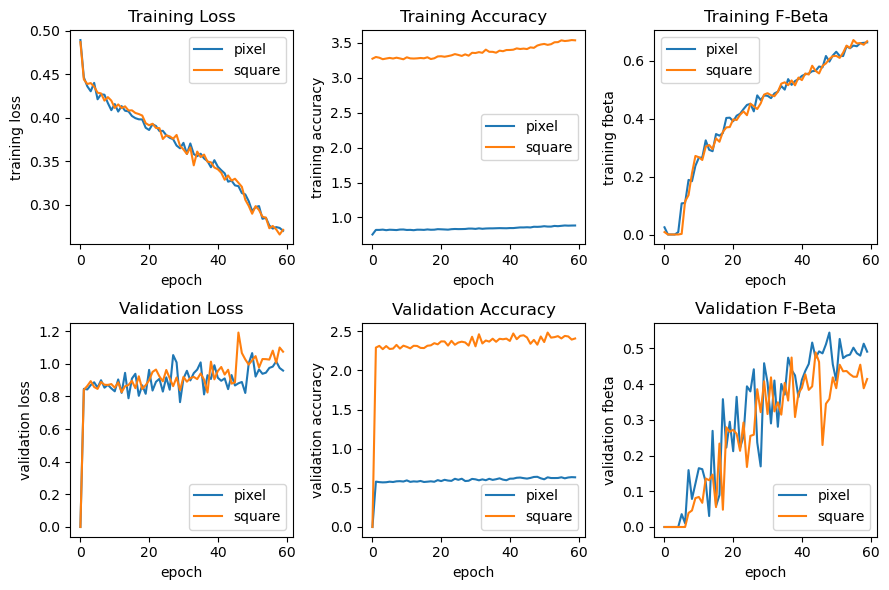

In [113]:
if TRAIN_RUN:
    plt.figure(figsize=(9, 6))
    # Plotting the training_loss vs epochs
    plt.subplot(231)
    plt.plot(train_loss_plot, label="pixel")
    plt.plot(train_loss_plot_square, label="square")
    plt.xlabel('epoch')
    plt.ylabel('training loss')
    plt.title("Training Loss")
    plt.legend()
    
    # Plotting the training accuracy
    plt.subplot(232)
    plt.plot(train_accuracy_plot, label="pixel")
    plt.plot(train_accuracy_plot_square, label="square")
    plt.xlabel('epoch')
    plt.ylabel('training accuracy')
    plt.title("Training Accuracy")
    plt.legend()

    # Plotting the training fbeta@0.5
    plt.subplot(233)
    plt.plot(train_fbeta_plot, label="pixel")
    plt.plot(train_fbeta_plot_square, label="square")
    plt.xlabel('epoch')
    plt.ylabel('training fbeta')
    plt.title("Training F-Beta")
    plt.legend()
    
    # Plotting the validation_loss vs epochs
    plt.subplot(234)
    plt.plot(val_loss_plot, label="pixel")
    plt.plot(val_loss_plot_square, label="square")
    plt.xlabel('epoch')
    plt.ylabel('validation loss')
    plt.title("Validation Loss")
    plt.legend()

    # Plotting the validation accuracy
    plt.subplot(235)
    plt.plot(val_accuracy_plot, label="pixel")
    plt.plot(val_accuracy_plot_square, label="square")
    plt.xlabel('epoch')
    plt.ylabel('validation accuracy')
    plt.title("Validation Accuracy")
    plt.legend()

    # Plotting the training fbeta@0.5
    plt.subplot(236)
    plt.plot(val_fbeta_plot, label="pixel")
    plt.plot(val_fbeta_plot_square, label="square")
    plt.xlabel('epoch')
    plt.ylabel('validation fbeta')
    plt.title("Validation F-Beta")
    plt.legend()
    
    plt.tight_layout();

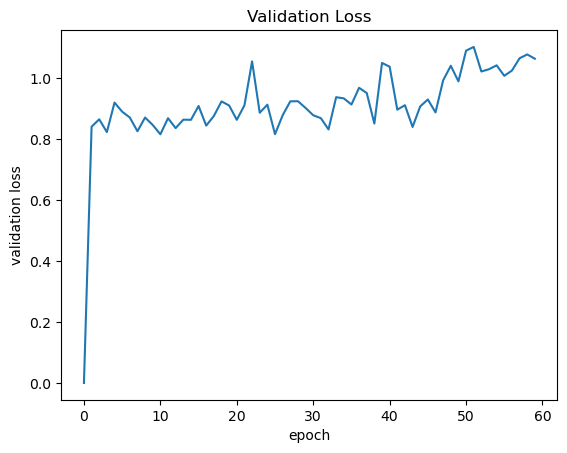

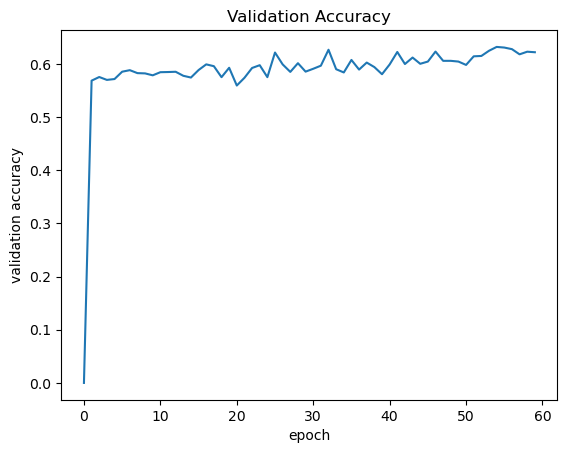

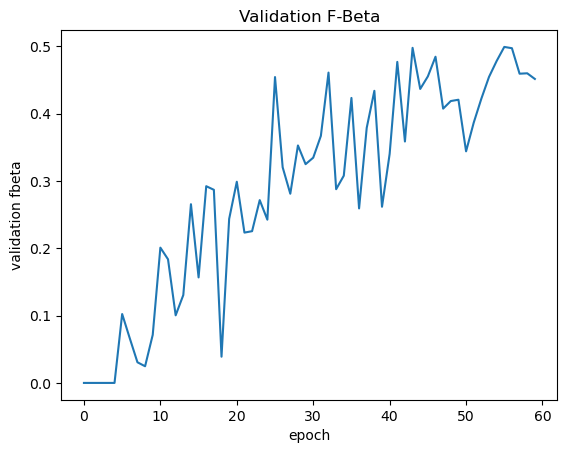

### Evaluate

In [18]:
# Clear memory before loading test fragments
train_dset.labels = None
train_dset.image_stacks = []
del train_loader, train_dset
gc.collect()

50

In [19]:
test_path = base_path / "test"
test_fragments = [train_path / fragment_name for fragment_name in test_path.iterdir()]
print("All fragments:", test_fragments)

All fragments: [PosixPath('train/test/b'), PosixPath('train/test/a')]


In [26]:
pred_images = []
model.eval()

outputs = []
eval_dset = SubvolumeDataset(image_stack, label, pixels_inside_rect)
eval_loader = data.DataLoader(eval_dset, batch_size=BATCH_SIZE, shuffle=False)
with torch.no_grad():
    for i, (subvolumes, _) in enumerate(tqdm(eval_loader)):
        output = model(subvolumes.to(DEVICE)).view(-1).sigmoid().cpu().numpy()
        outputs.append(output)
# we only load 1 fragment at a time
image_shape = eval_dset.image_stack[0].shape
eval_dset.labels = None
eval_dset.image_stack = None
del eval_loader
gc.collect()

pred_image = np.zeros(image_shape, dtype=np.uint8)
outputs = np.concatenate(outputs)
for (y, x), prob in zip(eval_dset.pixels[:outputs.shape[0]], outputs):
    pred_image[y ,x] = prob > 0.4
pred_images.append(pred_image)
    
eval_dset.pixels = None
del eval_dset
gc.collect()
#print("Finished", test_fragment)

100%|██████████| 20833/20833 [03:22<00:00, 102.93it/s]


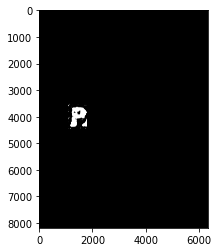

In [40]:
plt.imshow(pred_images[0], cmap='gray')

### Submission

In [ ]:
def rle(output):
    flat_img = np.where(output > 0.4, 1, 0).astype(np.uint8)
    starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
    ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
    starts_ix = np.where(starts)[0] + 2
    ends_ix = np.where(ends)[0] + 2
    lengths = ends_ix - starts_ix
    return " ".join(map(str, sum(zip(starts_ix, lengths), ())))

In [ ]:
submission = defaultdict(list)
for fragment_id, fragment_name in enumerate(test_fragments):
    submission["Id"].append(fragment_name.name)
    submission["Predicted"].append(rle(pred_images[fragment_id]))

pd.DataFrame.from_dict(submission).to_csv("/kaggle/working/submission.csv", index=False)

In [ ]:
pd.DataFrame.from_dict(submission)